In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=12'

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html
from brax.training import normalization


import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController
from common import do_local_apg, add_guassian_noise, add_uniform_noise, add_uniform_and_pareto_noise, add_sym_pareto_noise, do_one_rollout

from functools import partial

jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

12

In [2]:
episode_length = 1000
action_repeat = 4
batch_size = jax.local_device_count()
#noise_std = 0.2

noise_scale = 5.0
noise_beta = 2.0

apg_epochs = 200
normalize_observations=True

env_name = "halfcheetah"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, auto_reset=False)
env = env_fn()

In [3]:
key = jax.random.PRNGKey(0)
reset_keys = jax.random.split(key, num=jax.local_device_count())
_, model_key = jax.random.split(reset_keys[0])
noise_keys = jax.random.split(model_key, num=jax.local_device_count())

In [4]:
policy = MlpController(env.observation_size,env.action_size,64)
normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations, num_leading_batch_dims=1)

add_noise_pmap = jax.pmap(add_uniform_noise, in_axes=(None,None,0))
add_pareto_noise_pmap = jax.pmap(add_uniform_and_pareto_noise, in_axes=(None,None,None,0))

do_apg_pmap = jax.pmap(do_local_apg, in_axes = (None,None,None,None,0,0,None,None,None), static_broadcasted_argnums=(0,1,2,6,7,8))
do_rollout_pmap = jax.pmap(do_one_rollout, in_axes = (None,None,None,0,0,None,None,None), static_broadcasted_argnums=(0,1,5,6,7))


init_states = jax.pmap(env.reset)(reset_keys)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)

policy_params = policy.init(model_key, h0, x0)

best_reward = -float('inf')
meta_rewards_list = []

In [5]:
%%time
for i in range(20):
    noise_keys = jax.random.split(noise_keys[0], num=jax.local_device_count())
    train_keys = jax.random.split(noise_keys[0], num=jax.local_device_count())

    #policy_params_with_noise, noise = add_noise_pmap(policy_params, noise_std, noise_keys)
    policy_params_with_noise, noise1,noise2 = add_pareto_noise_pmap(policy_params, noise_beta, noise_scale, noise_keys)
    
    rewards_before, obs, acts, states_before = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, episode_length, action_repeat, normalize_observations)
    policy_params_trained, rewards_lists = do_apg_pmap(apg_epochs, env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, 1e-3, episode_length, action_repeat)
    rewards_after, obs, acts, states_after = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_trained, train_keys, episode_length, action_repeat, normalize_observations)
            
    print(jnp.any(policy_params_trained['params']['Dense_1']['kernel'] - policy_params_with_noise['params']['Dense_1']['kernel']))
    
    top_idx = sorted(range(len(rewards_lists)), key=lambda k: jnp.mean(rewards_lists[k][-5:]), reverse=True)
    
    normalizer_params = obs_normalizer_update_fn(normalizer_params, obs[top_idx[0],:])
    
    _, params_def = jax.tree_flatten(policy_params)
    params_flat, _ = jax.tree_flatten(policy_params_trained)
    top_params_flat = [param[top_idx[0]] for param in params_flat]
    top_params = jax.tree_unflatten(params_def, top_params_flat)
    
    
#     _, norm_def = jax.tree_flatten(normalizer_params)
#     norm_flat, _ = jax.tree_flatten(normalizer_params_all)
#     top_norm_flat = [param[top_idx[0]] for param in norm_flat]
#     top_norms = jax.tree_unflatten(norm_def, top_norm_flat)
    
    noise_beta -= .1
    
    if rewards_lists[top_idx[0]][-1] > best_reward:
        noise_beta = 2.0
        policy_params = top_params
        #normalizer_params = top_norms
        best_reward = rewards_lists[top_idx[0]][-1]
        
    meta_rewards_list.append(best_reward)
    
    done_idx = jnp.where(states_before.done[top_idx[0], :], size=1)[0].item()
    rewards_sum_before = jnp.sum(rewards_before[top_idx[0],:done_idx])

    done_idx = jnp.where(states_after.done[top_idx[0], :], size=1)[0].item()
    rewards_sum_after = jnp.sum(rewards_after[top_idx[0],:done_idx])

    print(f"{i} : best reward: {rewards_sum_before} -> {rewards_lists[top_idx[0]][-1]}  |  {rewards_sum_after}")
    print("Best reward so far: ", best_reward)
    print('--------------------------------------')

True
0 : best reward: -67.07861328125 -> 36.17432403564453  |  278.5411376953125
Best reward so far:  36.174324
--------------------------------------
True
1 : best reward: -71.173583984375 -> 210.48812866210938  |  170.4070587158203
Best reward so far:  210.48813
--------------------------------------
True
2 : best reward: 135.06906127929688 -> 547.3964233398438  |  562.393310546875
Best reward so far:  547.3964
--------------------------------------
True
3 : best reward: 538.0746459960938 -> 545.6260375976562  |  572.2451171875
Best reward so far:  547.3964
--------------------------------------
True
4 : best reward: 95.7562255859375 -> 571.0545043945312  |  540.3629150390625
Best reward so far:  571.0545
--------------------------------------
True
5 : best reward: 604.178955078125 -> 616.89794921875  |  655.2607421875
Best reward so far:  616.89795
--------------------------------------
True
6 : best reward: 632.5618896484375 -> 706.4189453125  |  658.7032470703125
Best reward so fa

In [6]:
jnp.any(policy_params_trained['params']['Dense_1']['kernel'] - policy_params_with_noise['params']['Dense_1']['kernel'])

DeviceArray(True, dtype=bool)

In [7]:
import brax.jumpy as jp
@jax.jit
def do_rnn_rollout(policy_params, normalizer_params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h, policy_params, normalizer_params  = carry

        normed_obs = obs_normalizer_apply_fn(normalizer_params, state.obs)
        h1 , actions = policy.apply(policy_params, h, normed_obs)
        #actions = jp.ones_like(actions)*0.0
        nstate = env.step(state, actions)    
        #h1 = jax.lax.cond(nstate.done, lambda x: jnp.zeros_like(h1), lambda x: h1, None)
        return (jax.lax.stop_gradient(nstate), h1, policy_params, normalizer_params), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0, policy_params, normalizer_params),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

631.7924470156431


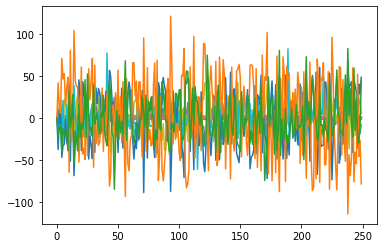

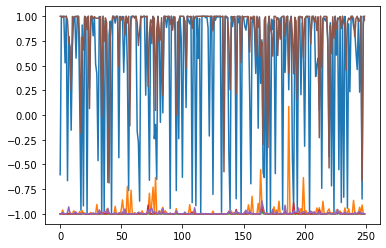

In [18]:
key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(policy_params, normalizer_params, reset_key)
plt.plot(obs);
plt.figure()
plt.plot(acts);
print(sum(rewards))

In [ ]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)

In [10]:
states.done

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.